# Data Scientist project submission - Ahmed Said Al Farsi

We will start off by importing the basic libraries numpy, pandas, matplotlib, and seaborn.

We will also declare the train and test datasets as variables to reduce clutter later on.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')


In [1624]:
#checking backend if inline
plt.get_backend()

'module://matplotlib_inline.backend_inline'

# Exploring the data

In [1625]:
#Verifying the integrity of my imports

display(df_train.head(1))
display(df_test.head(1))

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,2016,diesel,diesel,1.6,universal,False,owned,front,True,17,38,67,13150.0


,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,BMW,automatic,white,115000,2012,gasoline,gasoline,4.4,sedan,False,owned,all,True,32,104,146,20450.0


In [1626]:
#Using the shape method to find the entries or rows to be 50000 in the train dataset and 27000 in the test

print(df_train.shape,df_test.shape)

(50000, 17) (27000, 17)


Let's look at how many values are missing

In [1627]:
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)
df_train.isnull().sum()

manufacturer_name        0
transmission             0
color                    0
odometer_value           0
year_produced            0
engine_fuel              0
engine_type              0
engine_capacity          0
body_type                0
has_warranty             0
ownership                0
type_of_drive            0
is_exchangeable          0
number_of_photos         0
number_of_maintenance    0
duration_listed          0
price_usd                0
dtype: int64

In [1628]:
#checking dtypes for each column

df_train.dtypes

manufacturer_name         object
transmission              object
color                     object
odometer_value             int64
year_produced              int64
engine_fuel               object
engine_type               object
engine_capacity          float64
body_type                 object
has_warranty                bool
ownership                 object
type_of_drive             object
is_exchangeable             bool
number_of_photos           int64
number_of_maintenance      int64
duration_listed            int64
price_usd                float64
dtype: object

I noticed while skimming through the csv dataset via excel that there were discrepancies in ASCII output of some manufacturers.
As it turns out, they were in cyrillic characters so I assume it wasn't picked up properly

In [1629]:
print(df_train['manufacturer_name'].value_counts())

Volkswagen       5478
Opel             3545
BMW              3379
Ford             3290
Renault          3268
Audi             3238
Mercedes-Benz    2918
Peugeot          2475
Citroen          2092
Mazda            1712
Nissan           1698
Toyota           1593
Hyundai          1467
Skoda            1401
Kia              1171
Mitsubishi       1155
Fiat             1073
Honda            1047
Volvo             954
ВАЗ               643
Chevrolet         551
Chrysler          533
Subaru            396
Dodge             388
Seat              361
Suzuki            305
Rover             296
Lexus             291
Daewoo            281
Alfa Romeo        268
ГАЗ               252
Land Rover        231
Infiniti          215
LADA              203
Iveco             185
Jeep              148
Saab              139
Lancia            118
SsangYong         107
Mini               93
Geely              92
УАЗ                89
Dacia              83
Chery              82
Jaguar             81
Acura     

The describe method shows us the frequency of the most recurring variable from the name feature which happens to be Volkswagen:

In [1630]:
print(df_train.manufacturer_name.describe())

count          49985
unique            55
top       Volkswagen
freq            5478
Name: manufacturer_name, dtype: object


Here I look at how many cars have warranty, where I found out that only 571 out of 50000 entries do

In [1631]:
print(df_train['has_warranty'].value_counts(normalize = False))

False    49414
True       571
Name: has_warranty, dtype: int64


I used the mean of True boolean values which would give me the percentage of True to False for simplification

In [1632]:
print('percentage of cars that have warranty = ' + np.array2string(df_train['has_warranty'].mean()*100) + '%')

percentage of cars that have warranty = 1.1423427%


It's worth noting that cars with warranty are possible outliers when correlating the data, but I decided not to drop them

In [1633]:
sum_prices = sum (df_train['price_usd'])
haswarranty_sum = sum(df_train.loc[df_train['has_warranty']==1]['price_usd'])
nowarranty_sum = sum(df_train.loc[df_train['has_warranty']==0]['price_usd'])

df_warranty = pd.DataFrame({'status':['has_warranty','no_warranty'],'cumulative_price':[haswarranty_sum,nowarranty_sum], 'price_percentage':[haswarranty_sum/sum_prices *100 , nowarranty_sum/sum_prices *100]})
df_warranty.set_index('status', inplace= True)
display(df_warranty)

,cumulative_price,price_percentage
status,,
has_warranty,1.332619e+07,4.008396
no_warranty,3.191306e+08,95.991604


Investigating the prices and finding that the price of covered cars constitutes around 4% of the sum of all car prices.

We can see if cars that were made before 1970 are higher in price than the average car price of cars that were made after 1980

In [1634]:
#We will set the conditions where the cars are owned and do not have warranty to avoid outliers
classics = df_train.loc[(df_train['year_produced']<=1970) & (df_train['ownership'] == "owned") & (df_train['has_warranty']==0)]['price_usd']
modern = df_train.loc[(df_train['year_produced']>=1970) & (df_train['ownership'] == "owned") & (df_train['has_warranty']==0)]['price_usd']

classics_avg = classics.mean()
modern_avg = modern.mean()

classics_freq = classics.count()
modern_freq = modern.count()

classics_df = pd.DataFrame({'category':['classic','modern'], 'average_price':[classics_avg,modern_avg], 'number_of_cars': [classics_freq,modern_freq]})
classics_df.set_index('category', inplace=True)
display(classics_df)

,average_price,number_of_cars
category,,
classic,4858.170000,91
modern,6471.783679,48764


Surprisingly enough, the average price of classic cars is lower than modern cars

In [1635]:
df_train['ownership'].value_counts()

owned        48941
new            563
emergency      481
Name: ownership, dtype: int64

We can do the same to find average price per ownership

In [1636]:
owned = df_train.loc[(df_train['ownership'] == "owned")]['price_usd']
new = df_train.loc[(df_train['ownership'] == "new")]['price_usd']
emergency = df_train.loc[(df_train['ownership'] == "emergency")]['price_usd']

owned_avg = owned.mean()
new_avg = new.mean()
emergency_avg = emergency.mean()

ownership_df = pd.DataFrame({'ownership': ['new','owned','emergency'], 'avg_price':[new_avg, owned_avg, emergency_avg]})
ownership_df.set_index('ownership')

display(ownership_df)

,ownership,avg_price
0,new,24947.727780
1,owned,6488.576139
2,emergency,1775.135405


We can see that the average price of new cars is considerably higher than that of owned cars.

Also, cars used for emergency purposes are not desirable and thus the lower prices .

# Preliminary manipulation

Before moving on to data visualization, I decided to change the year_produced column to display car_age instead.

I prefer to use this method since this is more intuitive.

In [1637]:
now = pd.Timestamp.now()
df_train['year_produced'] = pd.Timestamp(now).year - df_train['year_produced']
df_train.rename({'year_produced' : 'car_age'} , axis = 1 , inplace = True)

In [1638]:
#We have to do the same to the test dataset
now = pd.Timestamp.now()
df_test['year_produced'] = pd.Timestamp(now).year - df_test['year_produced']
df_test.rename({'year_produced' : 'car_age'} , axis = 1 , inplace = True)

In [1639]:
display(df_train.head(1))
display(df_test.head(1))

,manufacturer_name,transmission,color,odometer_value,car_age,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,6,diesel,diesel,1.6,universal,False,owned,front,True,17,38,67,13150.0


,manufacturer_name,transmission,color,odometer_value,car_age,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,BMW,automatic,white,115000,10,gasoline,gasoline,4.4,sedan,False,owned,all,True,32,104,146,20450.0


We've discovered previously that there are missing values for enginer_capacity and therefore, we should drop them.

In [1640]:
df_test.dropna(inplace = True)
df_train.isnull().sum()

manufacturer_name        0
transmission             0
color                    0
odometer_value           0
car_age                  0
engine_fuel              0
engine_type              0
engine_capacity          0
body_type                0
has_warranty             0
ownership                0
type_of_drive            0
is_exchangeable          0
number_of_photos         0
number_of_maintenance    0
duration_listed          0
price_usd                0
dtype: int64

# Identifying correlations

We will use bivariate correlations to identify the most suitable variables for our model

In [1641]:
pearson_corr = df_train.corr()
kendall_corr = df_train.corr(method = "kendall")
spearman_corr = df_train.corr(method = "spearman")

pearson_df = pd.DataFrame(pearson_corr['price_usd'])
pearson_df.style.set_caption('Pearson Correlation')

,price_usd
odometer_value,-0.421754
car_age,-0.704525
engine_capacity,0.301269
has_warranty,0.277572
is_exchangeable,-0.004638
number_of_photos,0.316846
number_of_maintenance,0.058939
duration_listed,0.035907
price_usd,1.000000


In [1642]:
kendall_df = pd.DataFrame(kendall_corr['price_usd'])
kendall_df.style.set_caption('Kendall Correlation')

,price_usd
odometer_value,-0.321049
car_age,-0.683326
engine_capacity,0.176424
has_warranty,0.134523
is_exchangeable,-0.035165
number_of_photos,0.221554
number_of_maintenance,0.066613
duration_listed,0.028602
price_usd,1.000000


In [1643]:
spearman_df = pd.DataFrame(spearman_corr['price_usd'])
spearman_df.style.set_caption('Spearman Correlation')

,price_usd
odometer_value,-0.454666
car_age,-0.861929
engine_capacity,0.245790
has_warranty,0.164362
is_exchangeable,-0.042965
number_of_photos,0.316464
number_of_maintenance,0.095829
duration_listed,0.042288
price_usd,1.000000


We can see that the magnitude of the negative correlation between price and car age is the highest

# Data visualization - correlations

<function matplotlib.pyplot.show(close=None, block=None)>

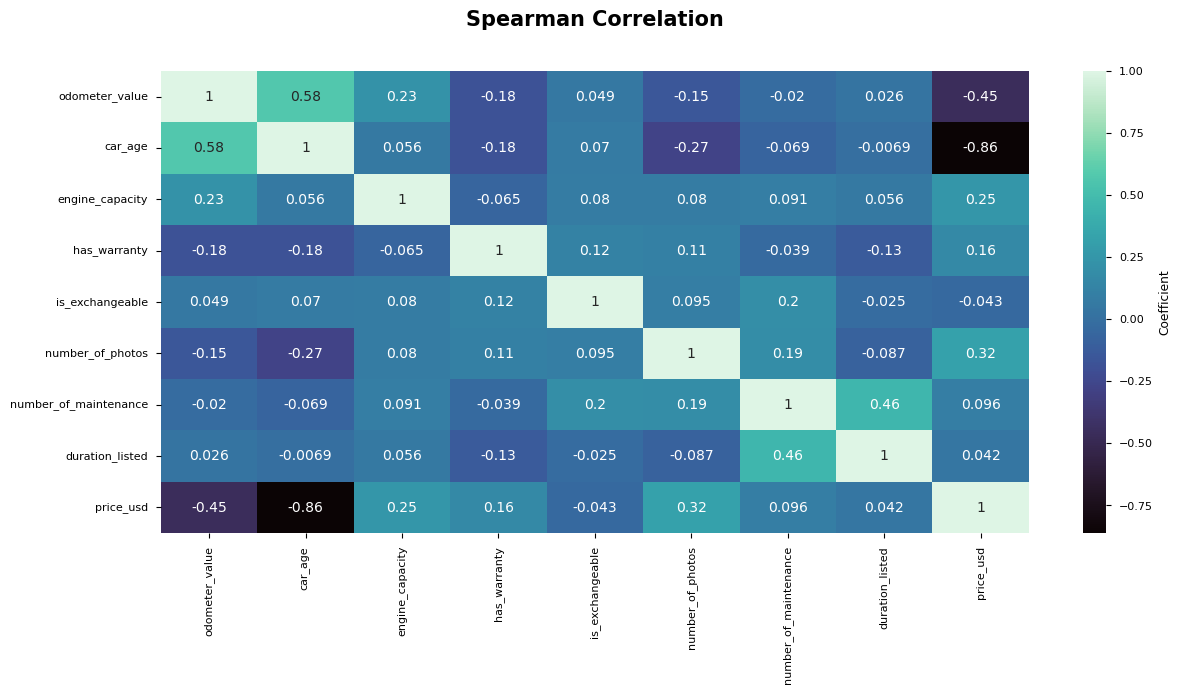

In [1644]:
sns.color_palette("mako", as_cmap = True)
plt.style.use(['default','seaborn-paper'])
plt.figure(figsize = (14,6))
fig1 = sns.heatmap(spearman_corr, cmap="mako", annot = True)
fig1.set_title('Spearman Correlation' , y = 1.08 , fontsize = 15 ,weight = 'bold')
fig1.collections[0].colorbar.set_label('Coefficient')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

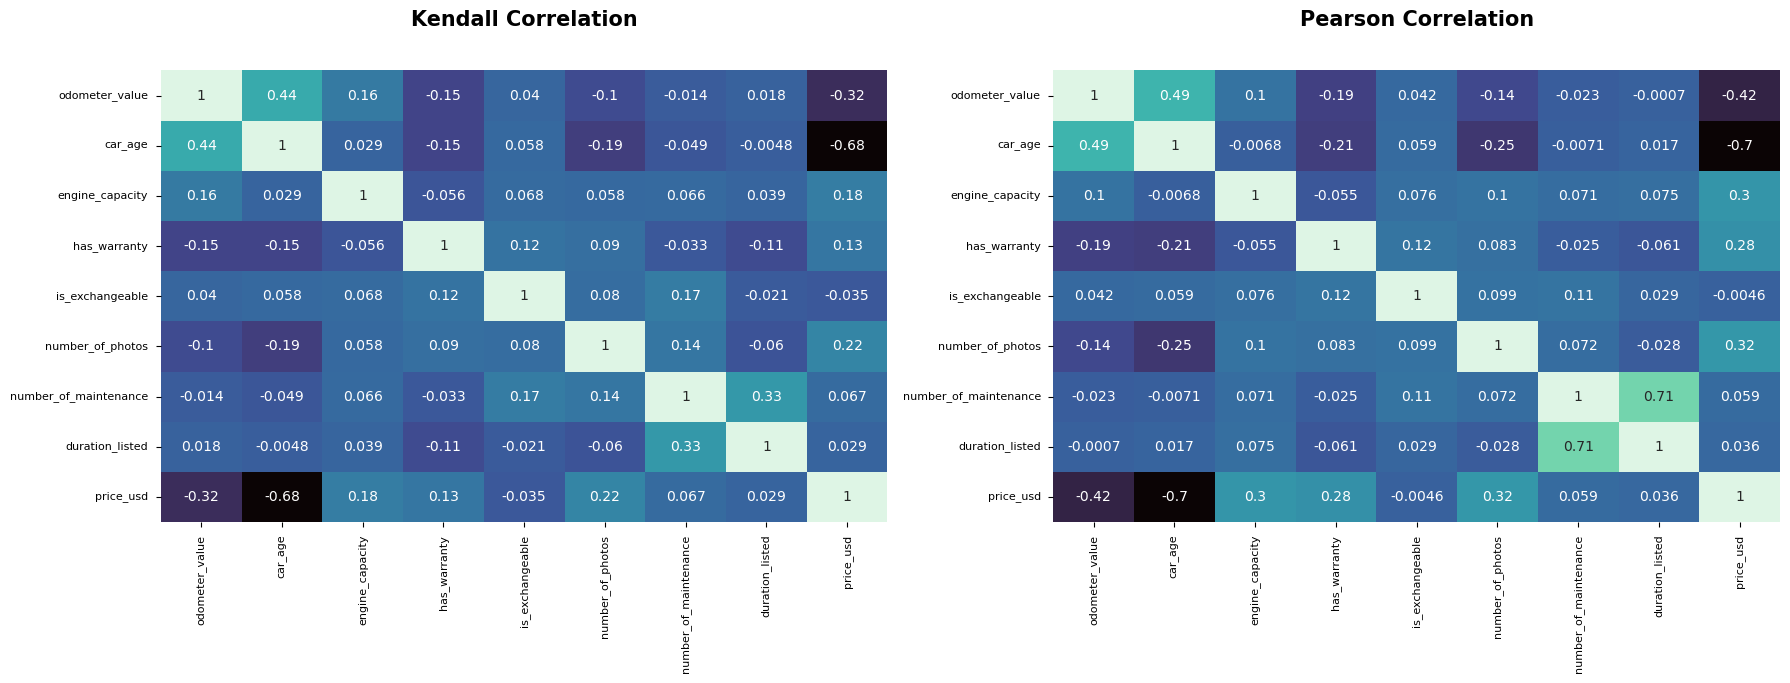

In [1645]:
fig2, (ax1,ax2) = plt.subplots(1,2,figsize = (18,7))
sns.heatmap(kendall_corr, ax=ax1, cmap="mako", annot = True, cbar = False)
sns.heatmap(pearson_corr, ax=ax2, cmap="mako", annot = True, cbar = False)
ax1.set_title('Kendall Correlation', y = 1.08 , fontsize = 15, weight = 'bold')
ax2.set_title('Pearson Correlation', y = 1.08 , fontsize = 15, weight = 'bold')
fig2.tight_layout()
plt.show

We will plot the price_usd vs car_age to see the relationship and prove the correlation

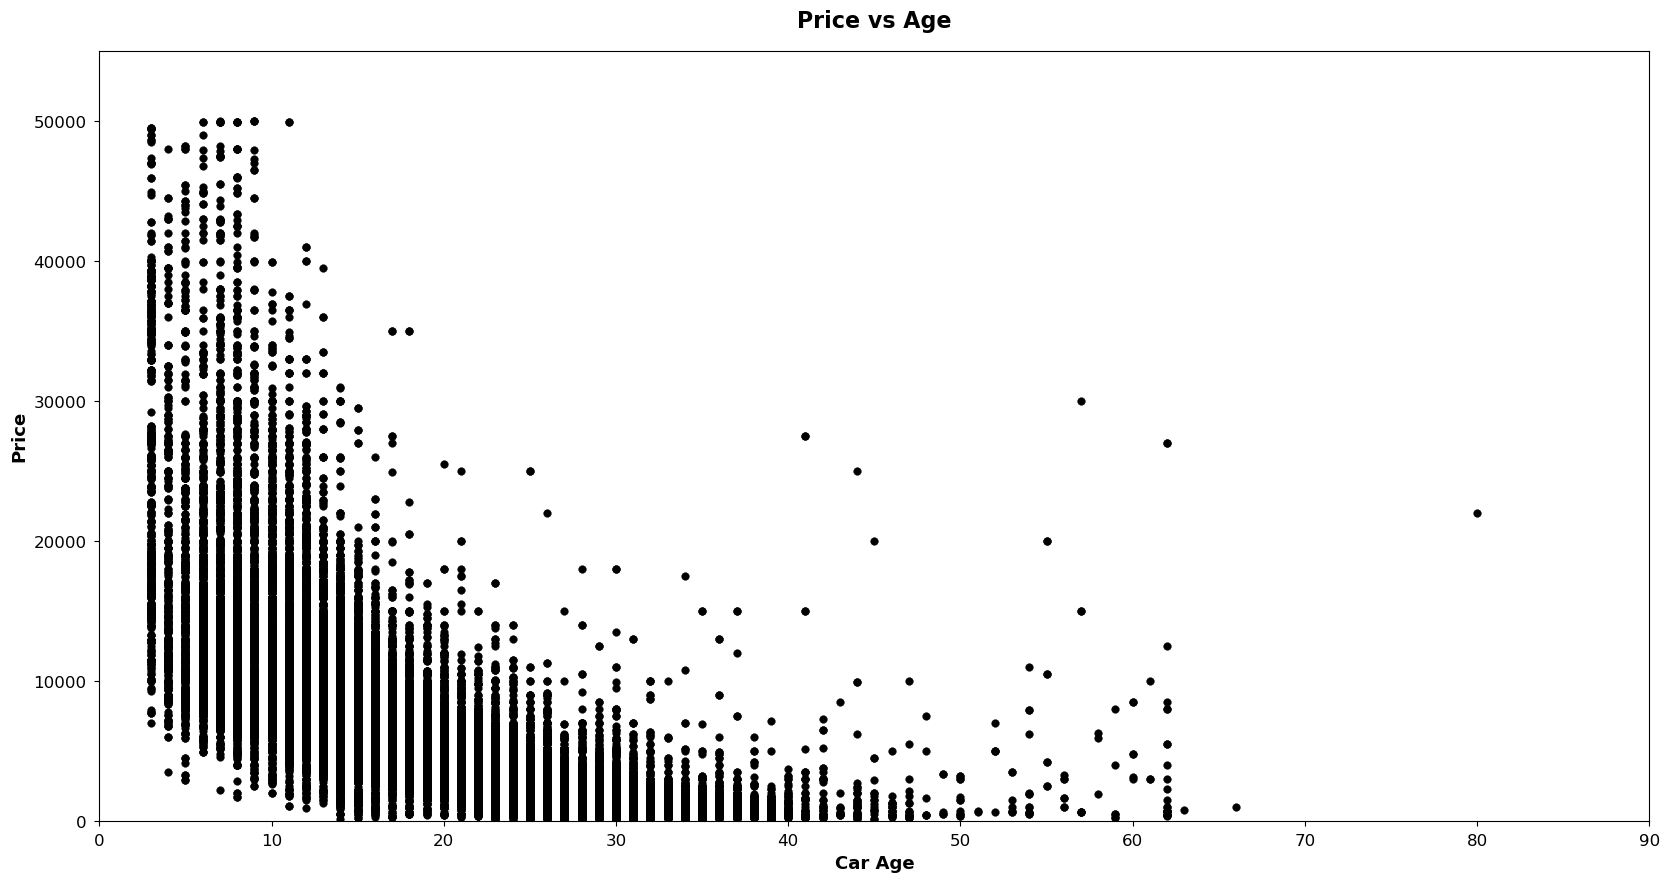

In [1646]:
x = df_train['car_age']
y = df_train['price_usd']
plt.figure(figsize = (20,10))
plt.scatter(x,y , color = 'black')
plt.xlim(0,90)
plt.ylim(0,55000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Car Age", fontsize = 13, weight = 'bold')
plt.ylabel("Price" , fontsize = 13, weight = 'bold')
plt.title("Price vs Age" , fontsize = 16 , weight = 'bold' , y = 1.02)
plt.show()


We can see that the spearman correlation resulted in a higher negative coefficient compared to both pearson's & kendall's
the plot displays a negative monotonic, non-linear relationship.

The relationship between price and other variables is not perfectly linear and the effect of outliers is evident.

Assuming we dropped the cars with warranty and emergency/new cars, pearson's correlation could have performed slightly better.

# Data Visualization - additional

<BarContainer object of 3 artists>

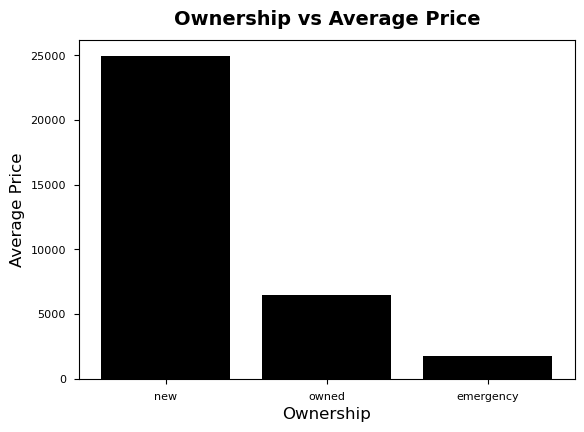

In [1647]:
x = ownership_df['ownership']
y = ownership_df['avg_price']
plt.xlabel("Ownership", fontsize = 12)
plt.ylabel("Average Price" , fontsize = 12)
plt.title("Ownership vs Average Price" , fontsize = 14 , weight = 'bold' , y = 1.02)

plt.bar(x,y , color = 'black')

# ML model - Simple Linear Regression using Age as the variable

In [1648]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_val_predict
#Since we have two different datasets designated for train & split, we will go ahead and declare the variables from each 
x_train = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1,1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)
#Here we will fit the variables to train the model & then pass the predict method
linreg = LinearRegression()
linreg.fit(x_train,y_train)
y_pred = linreg.predict(x_test)

In [1649]:
#As requested, we will also use the Mean Absolute Error to find the accuracy of our model
print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2913.1495676


In [1650]:
#cross validation
y_pred2 = cross_val_predict(linreg, x_test, y_test, cv =10)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred2)))

Mean absolute error = 2899.14787053


## ML model - Multiple Linear Regression using Age, Odometer Value, and engine capacity

We'll see here that adding two more variable gives us a lower MAE value. Since we can't model based on specific car models, the engine capacity will help alleviate that issue.

In [1651]:
x_train = df_train[['car_age','odometer_value', 'engine_capacity']]
y_train = df_train['price_usd']
x_test  = df_test[['car_age','odometer_value', 'engine_capacity']]
y_test  = df_test['price_usd']

linreg = LinearRegression()
linreg.fit(x_train,y_train)
y_pred = linreg.predict(x_test)
print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2574.46021969


In [1652]:
#cross validation
y_pred2 = cross_val_predict(linreg, x_test, y_test, cv =10)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred2)))

Mean absolute error = 2565.24417571


# ML model - SGD regression with robust scaling

We can create a pipeline to include scaling and SGDRegressor instead of manually fitting and transforming

In [1653]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

#We're going to have to reshape our arrays to be one column using the reshape function
x_train = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)

#Also, I will be using random_state = 42 to iterate on so that the same result is output everytime we run the code
pipe = Pipeline([('scale', RobustScaler()), ('model', SGDRegressor(random_state= 42))])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2917.61207997


# ML model - Polynomial Regression

This method would be more fitting since our scatter plot showed us a monotonic non-linear relationship. I also used a pipeline here to fit PolynomialFeatures

In [1654]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

x_train = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1,1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)

#I used a second degree polynomial based on the scatter plot
pipe = Pipeline([('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print(MAE(y_test, y_pred))

2480.8069216151302


# ML - Polynomial Regression with multiple features

This method gives us better MAE results than both linear regression and simple polynomial regression

In [1655]:
x_train = df_train[['car_age', 'odometer_value', 'engine_capacity']]
y_train = df_train['price_usd']
x_test = df_test[['car_age', 'odometer_value', 'engine_capacity']]
y_test = df_test['price_usd']

pipe = Pipeline([('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print(MAE(y_test, y_pred))

1893.4636491770204


# ML model - Lasso Regression

In [1656]:
from sklearn.linear_model import Lasso

Lassoreg = Lasso(alpha = 3000)
Lassoreg.fit(x_train, y_train)

y_pred = Lassoreg.predict(x_test)

print(MAE(y_test, y_pred))

2916.992608195747


# ML - Huber Regressor

In [1657]:
from sklearn.linear_model import HuberRegressor
x_train = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)

hreg = HuberRegressor()
hreg.fit(x_train, y_train)

y_pred = hreg.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2722.76880853


# ML model - Random Forest Regression

This proved to be the best model in terms of mean absolute error values


This is a tree-based regression model and scaling would make no difference

In [1658]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state = 42)
rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2439.94611224


# ML model - Random Forest Regression with multiple features

Since we achieved good results with the Random Forest Regression model, we can try using multiple features.
Logically, the odometer value would be a good fit as the second variable and engine capacity would follow.

In [1659]:
x_train = df_train[['car_age', 'odometer_value', 'engine_capacity']]
y_train = df_train['price_usd']
x_test = df_test[['car_age', 'odometer_value', 'engine_capacity']]
y_test = df_test['price_usd']

rfr = RandomForestRegressor(random_state = 42)
rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

print(rfr.score(x_test, y_test))


Mean absolute error = 1206.94599007
0.8907862390468962


# ML model - RANSAC regressor with polynomial features

Here I created a pipeline using RANSAC as the estimator and used polynomial features. This model does a good job in ignoring the outliers and produces better result. The MAE was less than that of the polynomial regression model I created before.

In [1660]:
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline

x_train = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1,1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)

#I use make_pipeline to show that we could avoid naming the steps
pipe = make_pipeline((PolynomialFeatures(degree=2)),(RANSACRegressor(random_state=42)))

pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)


print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))


Mean absolute error = 2465.00626756


# ML model - RANSAC regressor with multiple polynomial features

In [1661]:
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline

x_train = df_train[['car_age', 'odometer_value', 'engine_capacity']]
y_train = df_train['price_usd']
x_test  = df_test[['car_age', 'odometer_value', 'engine_capacity']]
y_test  = df_test['price_usd']

#I use make_pipeline to show that we could avoid naming the steps
pipe = make_pipeline((PolynomialFeatures(degree=2)),(RANSACRegressor(random_state=42)))

pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)


print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))

Mean absolute error = 2050.68811473


# Visualizing the Random Forest Tree model

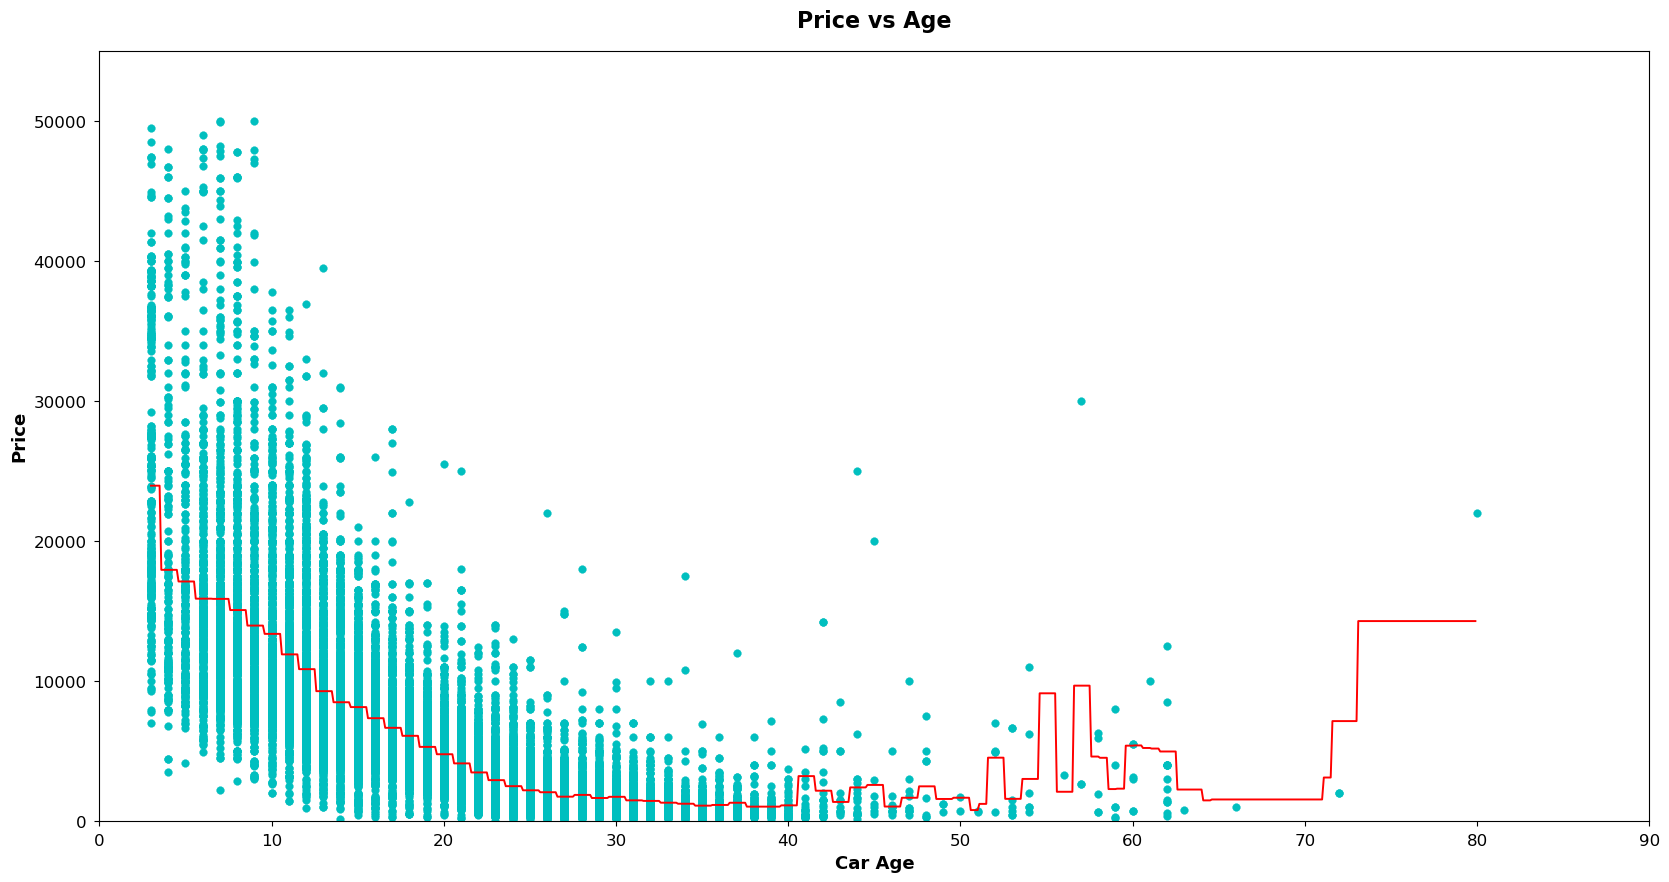

In [1662]:
x = df_test['car_age']
y = df_test['price_usd']
plt.figure(figsize = (20,10))
plt.scatter(x,y , color = 'c')
plt.xlim(0,90)
plt.ylim(0,55000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Car Age", fontsize = 13, weight = 'bold')
plt.ylabel("Price" , fontsize = 13, weight = 'bold')
plt.title("Price vs Age" , fontsize = 16 , weight = 'bold' , y = 1.02)

x = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)


x_grid = np.arange(min(x), max(x), 0.1)
x_grid = x_grid.reshape((len(x_grid), 1))

rfr = RandomForestRegressor(random_state = 42)
rfr.fit(x, y_train)

y_pred = rfr.predict(x_grid)

plt.plot(x_grid, y_pred, color = 'red') 

plt.show()

# Visualizing the RANSAC Polynomial Regression Model

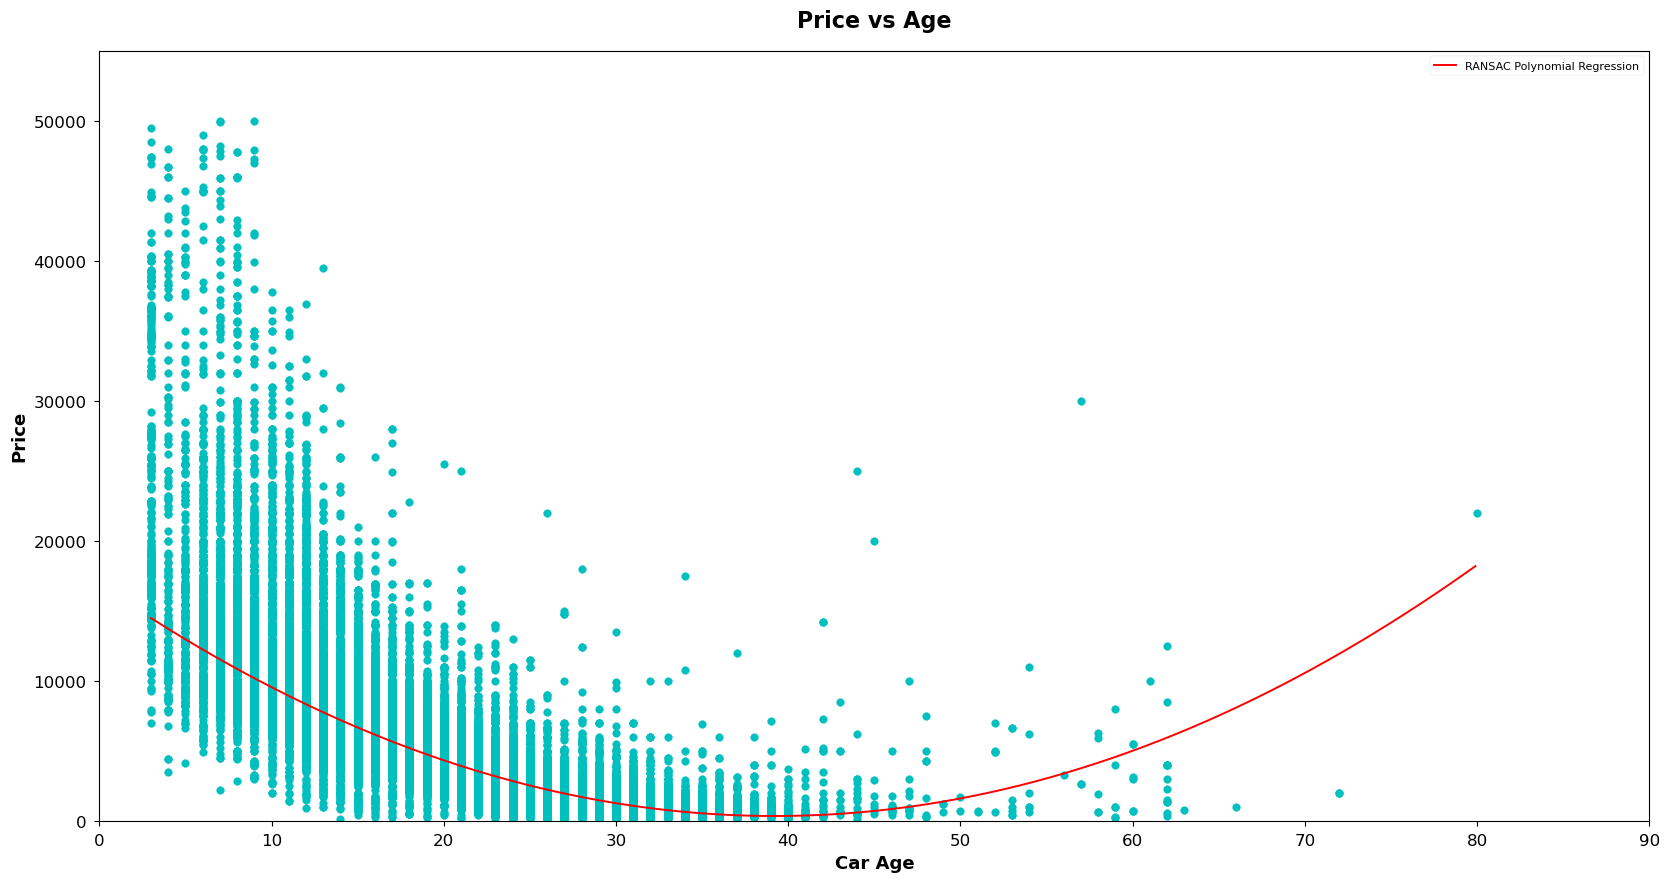

In [1663]:
x = df_test['car_age']
y = df_test['price_usd']

plt.figure(figsize = (20,10))
plt.scatter(x,y , color = 'c')
plt.xlim(0,90)
plt.ylim(0,55000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Car Age", fontsize = 13, weight = 'bold')
plt.ylabel("Price" , fontsize = 13, weight = 'bold')
plt.title("Price vs Age" , fontsize = 16 , weight = 'bold' , y = 1.02)

x = df_train['car_age'].values.reshape(-1,1)
y_train = df_train['price_usd'].values.reshape(-1,1)
x_test  = df_test['car_age'].values.reshape(-1,1)
y_test  = df_test['price_usd'].values.reshape(-1,1)

pipe = make_pipeline((PolynomialFeatures(degree=2)),(RANSACRegressor(random_state=42)))
pipe.fit(x, y_train)

x_grid = np.arange(min(x), max(x), 0.1)
x_grid = x_grid.reshape((len(x_grid), 1))
y_pred = pipe.predict(x_grid)

plt.plot(x_grid ,y_pred, color = 'red', label='RANSAC Polynomial Regression')
plt.legend()


plt.show()

# 4D Visualization

we can visualize the data in four dimensions:

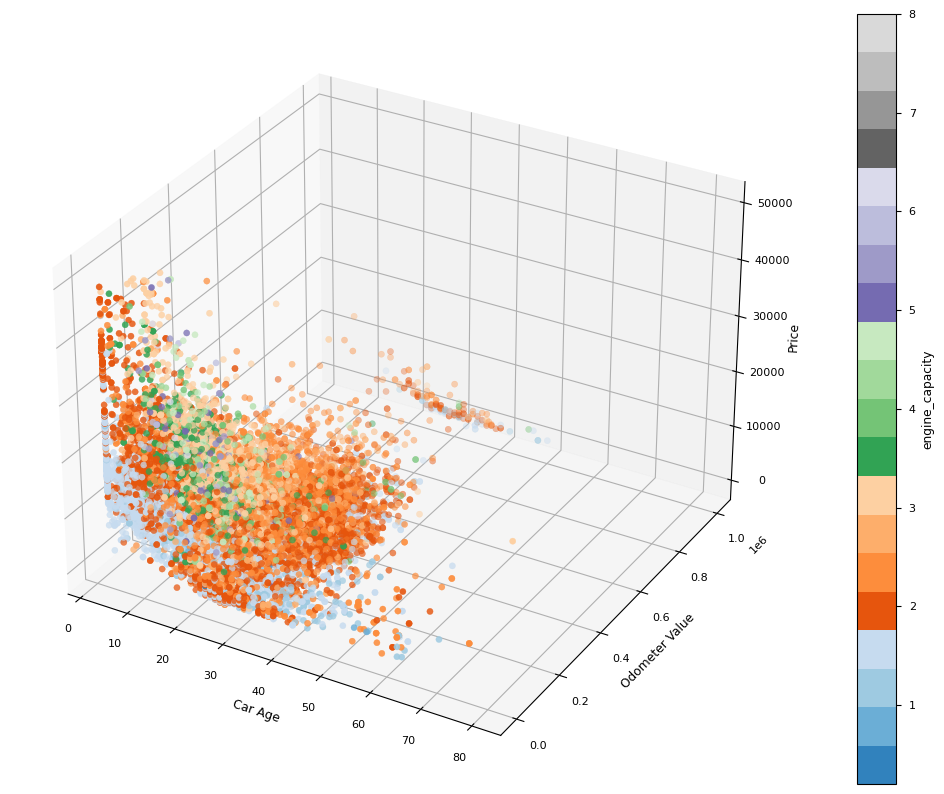

In [1664]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

x = df_test['car_age']
y = df_test['odometer_value']
z = df_test['price_usd']
c = df_test['engine_capacity']

model4d = ax.scatter(x, y, z, c=c, cmap='tab20c')
fig.colorbar(model4d, label = 'engine_capacity')

ax.set_xlabel("Car Age")
ax.set_ylabel("Odometer Value")
ax.set_zlabel("Price")


plt.show()


# Models on a Manufacturer Name Basis

Realistically, car prices depend on a multitude of factors and simply basing our prediction model on cars from different manufacturers with different characteristics is not an efficient approach. To drastically reduce the error, we can look at cars per manufacturer.

We can use cars made by Mazda for example:

In [1665]:
df_train_mazda = df_train.loc[df_train['manufacturer_name'] == "Mazda"]
df_test_mazda = df_test.loc[df_test['manufacturer_name'] == "Mazda"]

df_train.head()

,manufacturer_name,transmission,color,odometer_value,car_age,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,130000,6,diesel,diesel,1.6,universal,False,owned,front,True,17,38,67,13150.0
1,Renault,manual,brown,149000,10,gasoline,gasoline,1.6,sedan,False,owned,front,False,9,3,100,7500.0
2,Kia,automatic,brown,110000,8,gasoline,gasoline,1.6,hatchback,False,owned,front,False,5,10,91,12200.0
3,Opel,automatic,other,255100,15,gasoline,gasoline,1.8,hatchback,False,owned,front,False,10,4,91,4950.0
4,Mazda,manual,blue,650000,23,gasoline,gasoline,2.0,sedan,False,owned,front,True,5,7,62,3000.0


 ####          Polynomial Regression:

In [1666]:
x_train = df_train_mazda[['car_age', 'odometer_value', 'engine_capacity']]
y_train = df_train_mazda['price_usd']
x_test = df_test_mazda[['car_age', 'odometer_value', 'engine_capacity']]
y_test = df_test_mazda['price_usd']

pipe = Pipeline([('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print(MAE(y_test, y_pred))

974.5257761643705


#### Random Forest Tree Regression with multiple features:

In [1667]:
x_train = df_train_mazda[['car_age', 'engine_capacity', 'odometer_value']]
y_train = df_train_mazda['price_usd']
x_test = df_test_mazda[['car_age', 'engine_capacity', 'odometer_value']]
y_test = df_test_mazda['price_usd']

rfr = RandomForestRegressor(random_state = 42)
rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))
print(rfr.score(x_test, y_test))

Mean absolute error = 546.46525131
0.9668655009619165


As we can see here, predicting prices for a single manufacturer gives us considerably more accurate results.

## Multiple Random Forest Tree regression with categorical and numerical features

Now that we've discovered that including a categorical feature would be very critical to the accuracy of our model, we can use our best regression model and combine it with manufacturer's name:

In [1669]:
x_train = df_train[['car_age', 'odometer_value', 'engine_capacity', 'manufacturer_name']]
y_train = df_train['price_usd']
x_test  = df_test[['car_age', 'odometer_value', 'engine_capacity','manufacturer_name']]
y_test  = df_test['price_usd']

#this step is to assign dummy values to categorical data
x_train = pd.get_dummies(data=x_train, drop_first = True)
x_test = pd.get_dummies(data=x_test, drop_first = True)

rfr = RandomForestRegressor(random_state = 42)
rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

print("Mean absolute error = " + np.array2string(MAE(y_test,y_pred)))
rfr.score(x_test, y_test)

Mean absolute error = 818.4711408


0.9426691062593213

# Conclusion

We were tasked on predicting future car prices using the given datasets designated for training and testing. We looked at all the possible features that can be included in our model using different correlations. We then proceded to visualize the data to extract more insight before modeling. 

We then experimented with different machine learning models with the mean absolute error being the main accuracy criterion as requested. When it came to linear regression, adding more features slightly improved the quality of our prediction but due to the nature of the data, it was fairly inaccurate. The improvement in accuracy was notable when we trained our dataset with the polynomial regression model with multiple features. The best model by far was the random forest tree regression model. This model is a decision tree-based model which cross-validates the predicted values by itself and has proved to be reliable.  

A more meaningful approach was experimented with to predict prices by fitting the model for specific car manufacturers. Using Mazda as the car manufacturer, the random forest tree regression model produced an MAE of around 546 usd and an accuracy score of 96%.

Lastly, we arrived to the ultimate model that would provide us the most accuracy from our data: Random Forest Regression with Age, Odometer Value, Engine Capacity, and Manufacturer name. This model provided us with an MAE of 818 usd and an accuracy score of around 94%.